## Implementing finetuning a simple tranformer using JAX/NNX/Dynamax and comparing the results of Adam, EKF, DEKF and LoRA
### Venkatalakshmi Kottapalli

## Check for GPU

In [5]:
import jax
import jax.numpy as jnp
from jax import random, vmap, grad, jit
from jax.lib import xla_bridge
import flax.linen as nn
from flax.training import train_state
import optax
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from typing import Tuple, List
import time
from functools import partial

def setup_device():
    devices = jax.devices()
    backend = xla_bridge.get_backend().platform

    print(f"Backend: {backend.upper()}")
    print(f"Available devices: {len(devices)}")
    for i, device in enumerate(devices):
        print(f"  [{i}] {device.device_kind}: {device}")

    # Set default device
    if backend == 'gpu':
        print(f"\n✓ Using GPU acceleration")
        device = devices[0]
    elif backend == 'tpu':
        print(f"\n✓ Using TPU acceleration")
        device = devices[0]
    else:
        print(f"\n⚠ Using CPU only")
        device = devices[0]

    print("="*80 + "\n")
    return device, backend

# Run device setup
device, backend = setup_device()

Backend: GPU
Available devices: 1
  [0] NVIDIA L4: cuda:0

✓ Using GPU acceleration



Dynamax already installed!
JAX version: 0.5.3
Available devices: [CudaDevice(id=0)]

LOADING AND PREPARING DATA
Train set: (60000, 28, 28), Labels: (60000,)
Test set:  (10000, 28, 28), Labels: (10000,)
Applied domain shift: contrast x1.8, brightness +0.4


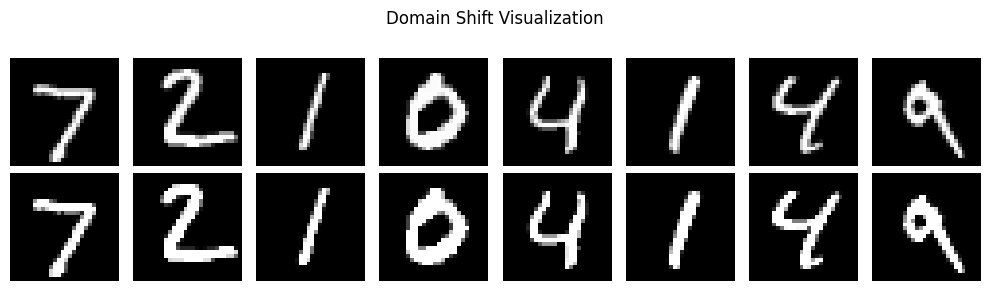

In [6]:
# =====================================
# 0. INSTALL DYNAMAX
# =====================================
import subprocess
import sys

try:
    import dynamax
    print("Dynamax already installed!")
except ImportError:
    print("Installing Dynamax...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "dynamax"])
    print("Dynamax installed successfully!")

# =====================================
# 1. SETUP AND IMPORTS
# =====================================
import jax
import jax.numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt
from flax import nnx
from tensorflow.keras.datasets import mnist
import copy
from jax.flatten_util import ravel_pytree
from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM
from dynamax.generalized_gaussian_ssm.inference import conditional_moments_gaussian_filter, EKFIntegrals

print("JAX version:", jax.__version__)
print("Available devices:", jax.devices())

# =====================================
# 2. DATA PREPARATION
# =====================================
print("\n" + "="*60)
print("LOADING AND PREPARING DATA")
print("="*60)

# Load MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

print(f"Train set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test set:  {X_test.shape}, Labels: {y_test.shape}")

# Create domain shift: increase contrast and add brightness
# This simulates a distribution shift between train and test
X_test_shifted = np.clip(((X_test - 0.5) * 1.8 + 0.5) + 0.4, 0, 1)
y_test_shifted = y_test

print("Applied domain shift: contrast x1.8, brightness +0.4")

# Visualize the domain shift
fig, axes = plt.subplots(2, 8, figsize=(10, 3))
for i in range(8):
    axes[0, i].imshow(X_test[i], cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(X_test_shifted[i], cmap="gray")
    axes[1, i].axis("off")
axes[0, 0].set_ylabel("Original", rotation=0, labelpad=40)
axes[1, 0].set_ylabel("Shifted", rotation=0, labelpad=40)
plt.suptitle("Domain Shift Visualization")
plt.tight_layout()
plt.show()

In [7]:
# =====================================
# 3. TRANSFORMER MODEL DEFINITION
# =====================================
print("\n" + "="*60)
print("DEFINING TRANSFORMER ARCHITECTURE")
print("="*60)

class SimpleAttention(nnx.Module):
    """Single-head self-attention mechanism"""
    def __init__(self, embed_dim, *, rngs: nnx.Rngs):
        self.embed_dim = embed_dim
        self.query = nnx.Linear(embed_dim, embed_dim, rngs=rngs)
        self.key = nnx.Linear(embed_dim, embed_dim, rngs=rngs)
        self.value = nnx.Linear(embed_dim, embed_dim, rngs=rngs)

    def __call__(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        scores = jnp.matmul(Q, K.transpose(0, 2, 1)) / jnp.sqrt(self.embed_dim)
        attn_weights = jax.nn.softmax(scores, axis=-1)
        output = jnp.matmul(attn_weights, V)
        return output


class TransformerBlock(nnx.Module):
    """Transformer block with self-attention and feed-forward network"""
    def __init__(self, embed_dim, ffn_dim, *, rngs: nnx.Rngs):
        self.attention = SimpleAttention(embed_dim, rngs=rngs)
        self.norm1 = nnx.LayerNorm(embed_dim, rngs=rngs)
        self.ffn1 = nnx.Linear(embed_dim, ffn_dim, rngs=rngs)
        self.ffn2 = nnx.Linear(ffn_dim, embed_dim, rngs=rngs)
        self.norm2 = nnx.LayerNorm(embed_dim, rngs=rngs)

    def __call__(self, x):
        # Self-attention with residual connection
        attn_out = self.attention(x)
        x = self.norm1(x + attn_out)

        # Feed-forward network with residual connection
        ffn_out = self.ffn2(jax.nn.relu(self.ffn1(x)))
        x = self.norm2(x + ffn_out)
        return x


class SimpleTransformer(nnx.Module):
    """Simple Vision Transformer for MNIST classification"""
    def __init__(self, patch_size, embed_dim, num_blocks, num_classes, *, rngs: nnx.Rngs):
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        # Linear projection of flattened patches
        self.patch_embed = nnx.Linear(patch_size * patch_size, embed_dim, rngs=rngs)

        # Stack of transformer blocks
        self.blocks = [TransformerBlock(embed_dim, embed_dim * 2, rngs=rngs)
                      for _ in range(num_blocks)]

        # Classification head
        self.fc = nnx.Linear(embed_dim, num_classes, rngs=rngs)

    def __call__(self, x):
        batch_size = x.shape[0]

        # Reshape image into patches
        # From (B, 28, 28) to (B, num_patches, patch_size^2)
        patches = jnp.reshape(x, (batch_size, 28 // self.patch_size, self.patch_size,
                                  28 // self.patch_size, self.patch_size))
        patches = jnp.transpose(patches, (0, 1, 3, 2, 4))
        patches = jnp.reshape(patches, (batch_size, -1, self.patch_size * self.patch_size))

        # Embed patches
        x = self.patch_embed(patches)

        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x)

        # Global average pooling and classification
        x = jnp.mean(x, axis=1)
        return self.fc(x)


class LoRALinear(nnx.Module):
    """Linear layer with Low-Rank Adaptation (LoRA)"""
    def __init__(self, in_features, out_features, rank=4, *, rngs: nnx.Rngs):
        # Frozen original weights
        self.weight = nnx.Param(nnx.initializers.lecun_normal()(
            rngs.params(), (out_features, in_features)))
        self.bias = nnx.Param(jnp.zeros(out_features))

        # Trainable low-rank matrices
        key1, key2 = jax.random.split(rngs.params())
        self.lora_A = nnx.Param(jax.random.normal(key1, (rank, in_features)) * 0.01)
        self.lora_B = nnx.Param(jnp.zeros((out_features, rank)))

        self.rank = rank
        self.scaling = 1.0

    def __call__(self, x):
        # Original path: x W^T + b
        original_out = x @ self.weight.value.T + self.bias.value

        # LoRA path: x A^T B^T
        lora_out = x @ self.lora_A.value.T @ self.lora_B.value.T

        return original_out + self.scaling * lora_out


class SimpleTransformerLoRA(nnx.Module):
    """Transformer with LoRA on the final FC layer"""
    def __init__(self, base_model, rank, *, rngs: nnx.Rngs):
        self.patch_size = base_model.patch_size
        self.embed_dim = base_model.embed_dim

        # Copy frozen layers from base model
        self.patch_embed = base_model.patch_embed
        self.blocks = base_model.blocks

        # Replace FC layer with LoRA version
        self.fc_lora = LoRALinear(base_model.embed_dim, 10, rank=rank, rngs=rngs)
        self.fc_lora.weight.value = base_model.fc.kernel.value.T
        self.fc_lora.bias.value = base_model.fc.bias.value

    def __call__(self, x):
        batch_size = x.shape[0]
        patches = jnp.reshape(x, (batch_size, 28 // self.patch_size, self.patch_size,
                                  28 // self.patch_size, self.patch_size))
        patches = jnp.transpose(patches, (0, 1, 3, 2, 4))
        patches = jnp.reshape(patches, (batch_size, -1, self.patch_size * self.patch_size))
        x = self.patch_embed(patches)
        for block in self.blocks:
            x = block(x)
        x = jnp.mean(x, axis=1)
        return self.fc_lora(x)


print("Architecture defined:")
print("  - SimpleAttention: single-head self-attention")
print("  - TransformerBlock: attention + FFN with residuals")
print("  - SimpleTransformer: patch embedding + blocks + FC")
print("  - LoRALinear: low-rank adaptation layer")
print("  - SimpleTransformerLoRA: transformer with LoRA FC layer")

# =====================================
# 4. UTILITY FUNCTIONS
# =====================================

def cross_entropy(logits, labels):
    """Cross-entropy loss"""
    y = jax.nn.one_hot(labels, 10)
    return -jnp.mean(jnp.sum(y * jax.nn.log_softmax(logits), axis=-1))


def accuracy(logits, labels):
    """Classification accuracy"""
    return jnp.mean(jnp.argmax(logits, -1) == labels)


def eval_batch(model, x, y):
    """Evaluate model on a batch"""
    logits = model(x)
    return cross_entropy(logits, y), accuracy(logits, y)


def extract_features(model, X):
    """Extract features from frozen transformer backbone"""
    batch_size = X.shape[0]
    patches = jnp.reshape(X, (batch_size, 28 // model.patch_size,
                             model.patch_size,
                             28 // model.patch_size,
                             model.patch_size))
    patches = jnp.transpose(patches, (0, 1, 3, 2, 4))
    patches = jnp.reshape(patches, (batch_size, -1,
                                   model.patch_size * model.patch_size))
    x = model.patch_embed(patches)
    for block in model.blocks:
        x = block(x)
    x = jnp.mean(x, axis=1)
    return x


def l2_diff(model1, model2):
    """Compute L2 norm of parameter difference between two models"""
    def flat_params(m):
        return jax.tree_util.tree_flatten(nnx.state(m))[0]
    p1, p2 = flat_params(model1), flat_params(model2)
    return float(sum(jnp.linalg.norm(a - b) for a, b in zip(p1, p2)))


DEFINING TRANSFORMER ARCHITECTURE
Architecture defined:
  - SimpleAttention: single-head self-attention
  - TransformerBlock: attention + FFN with residuals
  - SimpleTransformer: patch embedding + blocks + FC
  - LoRALinear: low-rank adaptation layer
  - SimpleTransformerLoRA: transformer with LoRA FC layer


In [8]:
# =====================================
# 5. BASELINE TRAINING
# =====================================
print("\n" + "="*60)
print("BASELINE TRAINING ON ORIGINAL DATA")
print("="*60)

# Initialize model
rngs = nnx.Rngs(0)
model = SimpleTransformer(
    patch_size=7,
    embed_dim=64,
    num_blocks=2,
    num_classes=10,
    rngs=rngs
)

print(f"Model configuration:")
print(f"  Patch size: 7x7")
print(f"  Embedding dimension: 64")
print(f"  Transformer blocks: 2")
print(f"  Output classes: 10")

# Count parameters
fc_param_count = model.fc.kernel.value.size + model.fc.bias.value.size
print(f"  FC layer parameters: {fc_param_count}")

# Train with Adam optimizer
optimizer = nnx.Optimizer(model, optax.adam(2e-3))

epochs = 30
batch_size = 512
train_losses, test_accs = [], []

print("\nTraining with Adam optimizer...")
for ep in range(epochs):
    # Sample random batch
    idx = np.random.choice(len(X_train), batch_size, replace=False)
    Xb, yb = X_train[idx], y_train[idx]

    # Compute loss and gradients
    def loss_fn(model):
        logits = model(Xb)
        loss = cross_entropy(logits, yb)
        return loss, logits

    (loss_value, _), grads = nnx.value_and_grad(loss_fn, has_aux=True)(model)
    optimizer.update(grads)

    # Evaluate periodically
    if (ep + 1) % 2 == 0 or ep == 0:
        l, a = eval_batch(model, X_test, y_test)
        train_losses.append(float(loss_value))
        test_accs.append(float(a))
        print(f"Epoch {ep+1}/{epochs}: train_loss={float(loss_value):.4f} test_acc={float(a):.4f}")

# Save baseline model
baseline_model = copy.deepcopy(model)

# Evaluate on shifted data
l_shift, a_shift = eval_batch(model, X_test_shifted, y_test_shifted)
print(f"\n{'='*60}")
print(f"Baseline performance:")
print(f"  Original test accuracy: {test_accs[-1]:.4f}")
print(f"  Shifted test accuracy:  {a_shift:.4f}")
print(f"  Performance drop:       {(test_accs[-1] - a_shift):.4f}")
print(f"{'='*60}\n")


BASELINE TRAINING ON ORIGINAL DATA
Model configuration:
  Patch size: 7x7
  Embedding dimension: 64
  Transformer blocks: 2
  Output classes: 10
  FC layer parameters: 650

Training with Adam optimizer...
Epoch 1/30: train_loss=2.4399 test_acc=0.2119
Epoch 2/30: train_loss=2.2510 test_acc=0.2397
Epoch 4/30: train_loss=2.1154 test_acc=0.3074
Epoch 6/30: train_loss=1.9530 test_acc=0.3683
Epoch 8/30: train_loss=1.8598 test_acc=0.3800
Epoch 10/30: train_loss=1.7684 test_acc=0.4232
Epoch 12/30: train_loss=1.6380 test_acc=0.4685
Epoch 14/30: train_loss=1.6074 test_acc=0.4724
Epoch 16/30: train_loss=1.5411 test_acc=0.4906
Epoch 18/30: train_loss=1.4541 test_acc=0.5151
Epoch 20/30: train_loss=1.4718 test_acc=0.5224
Epoch 22/30: train_loss=1.4348 test_acc=0.5397
Epoch 24/30: train_loss=1.4175 test_acc=0.5441
Epoch 26/30: train_loss=1.3440 test_acc=0.5658
Epoch 28/30: train_loss=1.2390 test_acc=0.5672
Epoch 30/30: train_loss=1.2448 test_acc=0.5921

Baseline performance:
  Original test accuracy

In [9]:
# =====================================
# 6. ADAPTATION METHODS
# =====================================

# Shared hyperparameters
num_adapt_epochs = 20
batch_size_adapt = 256
batch_size_ekf = 2000

# Results storage
results = {
    'adam': {'accs': [], 'losses': [], 'model': None},
    'ekf': {'accs': [], 'losses': [], 'model': None},
    'dekf': {'accs': [], 'losses': [], 'model': None},
    'lora': {'accs': [], 'losses': [], 'model': None}
}

# =====================================
# 6.1 ADAM ADAPTATION
# =====================================
print("\n" + "="*60)
print("METHOD 1: ADAM ADAPTATION")
print("="*60)

adam_model = copy.deepcopy(baseline_model)
adam_optimizer = nnx.Optimizer(adam_model.fc, optax.adam(1e-3))

print("Adapting FC layer with Adam optimizer...")
print(f"  Learning rate: 1e-3")
print(f"  Batch size: {batch_size_adapt}")
print(f"  Epochs: {num_adapt_epochs}")

for ep in range(num_adapt_epochs):
    # Shuffle data
    perm = np.random.permutation(len(X_test_shifted))
    X_shuffled = X_test_shifted[perm]
    y_shuffled = y_test_shifted[perm]

    num_batches = len(X_test_shifted) // batch_size_adapt
    epoch_loss = 0

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size_adapt
        end_idx = start_idx + batch_size_adapt
        Xb = X_shuffled[start_idx:end_idx]
        yb = y_shuffled[start_idx:end_idx]

        def adam_loss_fn(fc_layer):
            # Extract features and compute logits
            features = extract_features(adam_model, Xb)
            logits = features @ fc_layer.kernel.value + fc_layer.bias.value
            return cross_entropy(logits, yb)

        loss_value, grads = nnx.value_and_grad(adam_loss_fn)(adam_model.fc)
        adam_optimizer.update(grads)
        epoch_loss += float(loss_value)

    # Evaluate
    l, a = eval_batch(adam_model, X_test_shifted, y_test_shifted)
    results['adam']['losses'].append(float(l))
    results['adam']['accs'].append(float(a))
    print(f"Epoch {ep+1}/{num_adapt_epochs}: loss={float(l):.4f} acc={float(a):.4f}")

results['adam']['model'] = adam_model
print(f"Adam final accuracy: {results['adam']['accs'][-1]:.4f}")
print(f"Improvement: {(results['adam']['accs'][-1] - a_shift):.4f}")

# =====================================
# 6.2 EKF ADAPTATION (FULL COVARIANCE)
# =====================================
print("\n" + "="*60)
print("METHOD 2: EXTENDED KALMAN FILTER (FULL COVARIANCE)")
print("="*60)

ekf_model = copy.deepcopy(baseline_model)

# Flatten FC layer parameters
fc_params = nnx.state(ekf_model.fc)
flat_params, unflatten_fn = ravel_pytree(fc_params)
state_dim = flat_params.size

print(f"FC layer parameter count: {state_dim}")
print(f"Full covariance matrix: {state_dim}x{state_dim} = {state_dim**2:,} elements")

# FC forward function
def fc_forward(flat_params_val, features):
    unflattened = unflatten_fn(flat_params_val)
    W = unflattened['kernel'].value
    b = unflattened['bias'].value
    return features @ W + b

# EKF hyperparameters
prior_var = 0.1
dynamic_sigma = 1e-4

# Initialize EKF
initial_mean = flat_params
initial_covariance = jnp.eye(state_dim) * prior_var
dynamics_function = lambda w, x: w
dynamics_covariance = jnp.eye(state_dim) * dynamic_sigma

def emission_mean_function(w, x):
    logits = fc_forward(w, x)
    return jax.nn.softmax(logits)

def emission_cov_function(w, x):
    probs = emission_mean_function(w, x)
    return jnp.diag(probs * (1 - probs)) + 1e-5 * jnp.eye(10)

ekf_params = ParamsGGSSM(
    initial_mean=initial_mean,
    initial_covariance=initial_covariance,
    dynamics_function=dynamics_function,
    dynamics_covariance=dynamics_covariance,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function
)

print("\nRunning EKF with full covariance...")
features = extract_features(ekf_model, X_test_shifted)
observations = jax.nn.one_hot(y_test_shifted, 10)
num_batches = len(X_test_shifted) // batch_size_ekf

for ep in range(num_adapt_epochs):
    print(f"\nEKF Epoch {ep+1}/{num_adapt_epochs}")

    perm = np.random.permutation(len(X_test_shifted))
    features_shuffled = features[perm]
    obs_shuffled = observations[perm]

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size_ekf
        end_idx = start_idx + batch_size_ekf

        batch_features = features_shuffled[start_idx:end_idx]
        batch_obs = obs_shuffled[start_idx:end_idx]

        # Run Gaussian filter
        posterior = conditional_moments_gaussian_filter(
            ekf_params,
            EKFIntegrals(),
            batch_obs,
            inputs=batch_features
        )

        # Update EKF parameters with posterior
        ekf_params = ParamsGGSSM(
            initial_mean=posterior.filtered_means[-1],
            initial_covariance=posterior.filtered_covariances[-1],
            dynamics_function=dynamics_function,
            dynamics_covariance=dynamics_covariance,
            emission_mean_function=emission_mean_function,
            emission_cov_function=emission_cov_function
        )

    # Update model with filtered parameters
    final_params = unflatten_fn(posterior.filtered_means[-1])
    ekf_model.fc.kernel.value = final_params['kernel'].value
    ekf_model.fc.bias.value = final_params['bias'].value

    # Evaluate
    l, a = eval_batch(ekf_model, X_test_shifted, y_test_shifted)
    results['ekf']['losses'].append(float(l))
    results['ekf']['accs'].append(float(a))
    print(f"  loss={float(l):.4f} acc={float(a):.4f}")

results['ekf']['model'] = ekf_model
print(f"\nEKF final accuracy: {results['ekf']['accs'][-1]:.4f}")
print(f"Improvement: {(results['ekf']['accs'][-1] - a_shift):.4f}")

# =====================================
# 6.3 DECOUPLED EKF ADAPTATION
# =====================================
print("\n" + "="*60)
print("METHOD 3: DECOUPLED EKF (LAYER-WISE)")
print("="*60)

dekf_model = copy.deepcopy(baseline_model)

# Partition FC layer into parameter groups
fc_kernel = dekf_model.fc.kernel.value
fc_bias = dekf_model.fc.bias.value

print("Parameter groups:")
print(f"  Group 1 (Kernel): shape={fc_kernel.shape}, params={fc_kernel.size}")
print(f"  Group 2 (Bias):   shape={fc_bias.shape}, params={fc_bias.size}")

# Flatten each group
kernel_flat, kernel_unflatten = ravel_pytree(fc_kernel)
bias_flat, bias_unflatten = ravel_pytree(fc_bias)

dekf_cov_size = kernel_flat.size**2 + bias_flat.size**2
print(f"\nCovariance complexity:")
print(f"  Standard EKF: {state_dim}x{state_dim} = {state_dim**2:,} elements")
print(f"  DEKF Group 1: {kernel_flat.size}x{kernel_flat.size} = {kernel_flat.size**2:,} elements")
print(f"  DEKF Group 2: {bias_flat.size}x{bias_flat.size} = {bias_flat.size**2:,} elements")
print(f"  DEKF Total:   {dekf_cov_size:,} elements")
print(f"  Reduction:    {state_dim**2 / dekf_cov_size:.2f}x")

# Parameter group class
class ParameterGroup:
    def __init__(self, name, flat_params, unflatten_fn, prior_var=0.1, dynamic_sigma=1e-4):
        self.name = name
        self.flat_params = flat_params
        self.unflatten_fn = unflatten_fn
        self.state_dim = flat_params.size
        self.initial_mean = flat_params
        self.initial_covariance = jnp.eye(self.state_dim) * prior_var
        self.dynamics_function = lambda w, x: w
        self.dynamics_covariance = jnp.eye(self.state_dim) * dynamic_sigma

    def create_emission_functions(self, group_forward_fn):
        def emission_mean_function(w, x):
            return group_forward_fn(w, x)
        def emission_cov_function(w, x):
            probs = emission_mean_function(w, x)
            return jnp.diag(probs * (1 - probs)) + 1e-5 * jnp.eye(10)
        return emission_mean_function, emission_cov_function

# Create parameter groups
kernel_group = ParameterGroup("Kernel", kernel_flat, kernel_unflatten,
                              prior_var=0.1, dynamic_sigma=1e-4)
bias_group = ParameterGroup("Bias", bias_flat, bias_unflatten,
                            prior_var=0.01, dynamic_sigma=1e-5)

# Forward functions for each group
def kernel_forward(kernel_flat_val, features):
    kernel_val = kernel_group.unflatten_fn(kernel_flat_val)
    bias_val = dekf_model.fc.bias.value
    return jax.nn.softmax(features @ kernel_val + bias_val)

def bias_forward(bias_flat_val, features):
    kernel_val = dekf_model.fc.kernel.value
    bias_val = bias_group.unflatten_fn(bias_flat_val)
    return jax.nn.softmax(features @ kernel_val + bias_val)

# Create emission functions
kernel_emission_mean, kernel_emission_cov = kernel_group.create_emission_functions(kernel_forward)
bias_emission_mean, bias_emission_cov = bias_group.create_emission_functions(bias_forward)

# Initialize EKF for each group
kernel_ekf_params = ParamsGGSSM(
    initial_mean=kernel_group.initial_mean,
    initial_covariance=kernel_group.initial_covariance,
    dynamics_function=kernel_group.dynamics_function,
    dynamics_covariance=kernel_group.dynamics_covariance,
    emission_mean_function=kernel_emission_mean,
    emission_cov_function=kernel_emission_cov
)

bias_ekf_params = ParamsGGSSM(
    initial_mean=bias_group.initial_mean,
    initial_covariance=bias_group.initial_covariance,
    dynamics_function=bias_group.dynamics_function,
    dynamics_covariance=bias_group.dynamics_covariance,
    emission_mean_function=bias_emission_mean,
    emission_cov_function=bias_emission_cov
)

ekf_params_list = [kernel_ekf_params, bias_ekf_params]

print("\nRunning Decoupled EKF...")
features = extract_features(dekf_model, X_test_shifted)
observations = jax.nn.one_hot(y_test_shifted, 10)

for ep in range(num_adapt_epochs):
    print(f"\nDEKF Epoch {ep+1}/{num_adapt_epochs}")

    perm = np.random.permutation(len(X_test_shifted))
    features_shuffled = features[perm]
    obs_shuffled = observations[perm]

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size_ekf
        end_idx = start_idx + batch_size_ekf
        batch_features = features_shuffled[start_idx:end_idx]
        batch_obs = obs_shuffled[start_idx:end_idx]

        updated_ekf_params = []

        # Update Group 1: Kernel
        posterior_kernel = conditional_moments_gaussian_filter(
            ekf_params_list[0], EKFIntegrals(), batch_obs, inputs=batch_features
        )
        kernel_updated = kernel_group.unflatten_fn(posterior_kernel.filtered_means[-1])
        dekf_model.fc.kernel.value = kernel_updated

        kernel_ekf_params = ParamsGGSSM(
            initial_mean=posterior_kernel.filtered_means[-1],
            initial_covariance=posterior_kernel.filtered_covariances[-1],
            dynamics_function=kernel_group.dynamics_function,
            dynamics_covariance=kernel_group.dynamics_covariance,
            emission_mean_function=kernel_emission_mean,
            emission_cov_function=kernel_emission_cov
        )
        updated_ekf_params.append(kernel_ekf_params)

        # Update Group 2: Bias
        posterior_bias = conditional_moments_gaussian_filter(
            ekf_params_list[1], EKFIntegrals(), batch_obs, inputs=batch_features
        )
        bias_updated = bias_group.unflatten_fn(posterior_bias.filtered_means[-1])
        dekf_model.fc.bias.value = bias_updated

        bias_ekf_params = ParamsGGSSM(
            initial_mean=posterior_bias.filtered_means[-1],
            initial_covariance=posterior_bias.filtered_covariances[-1],
            dynamics_function=bias_group.dynamics_function,
            dynamics_covariance=bias_group.dynamics_covariance,
            emission_mean_function=bias_emission_mean,
            emission_cov_function=bias_emission_cov
        )
        updated_ekf_params.append(bias_ekf_params)

        ekf_params_list = updated_ekf_params

    # Evaluate
    l, a = eval_batch(dekf_model, X_test_shifted, y_test_shifted)
    results['dekf']['losses'].append(float(l))
    results['dekf']['accs'].append(float(a))
    print(f"  loss={float(l):.4f} acc={float(a):.4f}")

results['dekf']['model'] = dekf_model
print(f"\nDEKF final accuracy: {results['dekf']['accs'][-1]:.4f}")
print(f"Improvement: {(results['dekf']['accs'][-1] - a_shift):.4f}")

# =====================================
# 6.4 LoRA ADAPTATION
# =====================================
print("\n" + "="*60)
print("METHOD 4: LOW-RANK ADAPTATION (LoRA)")
print("="*60)

# Create LoRA model
lora_rngs = nnx.Rngs(0)
lora_rank = 8
lora_model = SimpleTransformerLoRA(baseline_model, lora_rank, rngs=lora_rngs)

num_lora_params = lora_rank * 64 + lora_rank * 10
print(f"LoRA configuration:")
print(f"  Rank: {lora_rank}")
print(f"  Matrix A: {lora_rank}x64")
print(f"  Matrix B: 10x{lora_rank}")
print(f"  Trainable parameters: {num_lora_params}")
print(f"  Original FC parameters: {fc_param_count}")

# Count total FC layer parameters manually
fc_param_count = (baseline_model.fc.kernel.value.size +
                  baseline_model.fc.bias.value.size)
print(f"  Original FC parameters: {fc_param_count}")
print(f"  Parameter efficiency: {num_lora_params / fc_param_count:.2%}")

# Create mask for trainable parameters
def create_lora_mask(model_state):
    mask = jax.tree_map(lambda x: jnp.zeros_like(x), model_state)
    mask['fc_lora']['lora_A'] = jax.tree_map(lambda x: jnp.ones_like(x),
                                              model_state['fc_lora']['lora_A'])
    mask['fc_lora']['lora_B'] = jax.tree_map(lambda x: jnp.ones_like(x),
                                              model_state['fc_lora']['lora_B'])
    return mask

lora_optimizer = nnx.Optimizer(lora_model, optax.adam(1e-3))
param_mask = create_lora_mask(nnx.state(lora_model))

print("\nTraining LoRA adaptation...")
for ep in range(num_adapt_epochs):
    perm = np.random.permutation(len(X_test_shifted))
    X_shuffled = X_test_shifted[perm]
    y_shuffled = y_test_shifted[perm]

    num_batches_lora = len(X_test_shifted) // batch_size_adapt

    for batch_idx in range(num_batches_lora):
        start_idx = batch_idx * batch_size_adapt
        end_idx = start_idx + batch_size_adapt
        Xb = X_shuffled[start_idx:end_idx]
        yb = y_shuffled[start_idx:end_idx]

        def lora_loss_fn(model):
            logits = model(Xb)
            return cross_entropy(logits, yb)

        loss_value, grads = nnx.value_and_grad(lora_loss_fn)(lora_model)

        # Apply mask to only update LoRA parameters
        masked_grads = jax.tree_map(lambda g, m: g * m, grads, param_mask)
        lora_optimizer.update(masked_grads)

    # Evaluate
    l, a = eval_batch(lora_model, X_test_shifted, y_test_shifted)
    results['lora']['losses'].append(float(l))
    results['lora']['accs'].append(float(a))
    print(f"Epoch {ep+1}/{num_adapt_epochs}: loss={float(l):.4f} acc={float(a):.4f}")

results['lora']['model'] = lora_model
print(f"\nLoRA final accuracy: {results['lora']['accs'][-1]:.4f}")
print(f"Improvement: {(results['lora']['accs'][-1] - a_shift):.4f}")


METHOD 1: ADAM ADAPTATION
Adapting FC layer with Adam optimizer...
  Learning rate: 1e-3
  Batch size: 256
  Epochs: 20
Epoch 1/20: loss=1.2007 acc=0.6052
Epoch 2/20: loss=1.1760 acc=0.6101
Epoch 3/20: loss=1.1591 acc=0.6099
Epoch 4/20: loss=1.1458 acc=0.6170
Epoch 5/20: loss=1.1345 acc=0.6161
Epoch 6/20: loss=1.1254 acc=0.6212
Epoch 7/20: loss=1.1172 acc=0.6234
Epoch 8/20: loss=1.1102 acc=0.6236
Epoch 9/20: loss=1.1034 acc=0.6270
Epoch 10/20: loss=1.0976 acc=0.6287
Epoch 11/20: loss=1.0923 acc=0.6335
Epoch 12/20: loss=1.0875 acc=0.6323
Epoch 13/20: loss=1.0826 acc=0.6356
Epoch 14/20: loss=1.0786 acc=0.6364
Epoch 15/20: loss=1.0746 acc=0.6385
Epoch 16/20: loss=1.0711 acc=0.6396
Epoch 17/20: loss=1.0672 acc=0.6404
Epoch 18/20: loss=1.0640 acc=0.6401
Epoch 19/20: loss=1.0608 acc=0.6423
Epoch 20/20: loss=1.0580 acc=0.6443
Adam final accuracy: 0.6443
Improvement: 0.0512

METHOD 2: EXTENDED KALMAN FILTER (FULL COVARIANCE)
FC layer parameter count: 650
Full covariance matrix: 650x650 = 422,


GENERATING VISUALIZATIONS


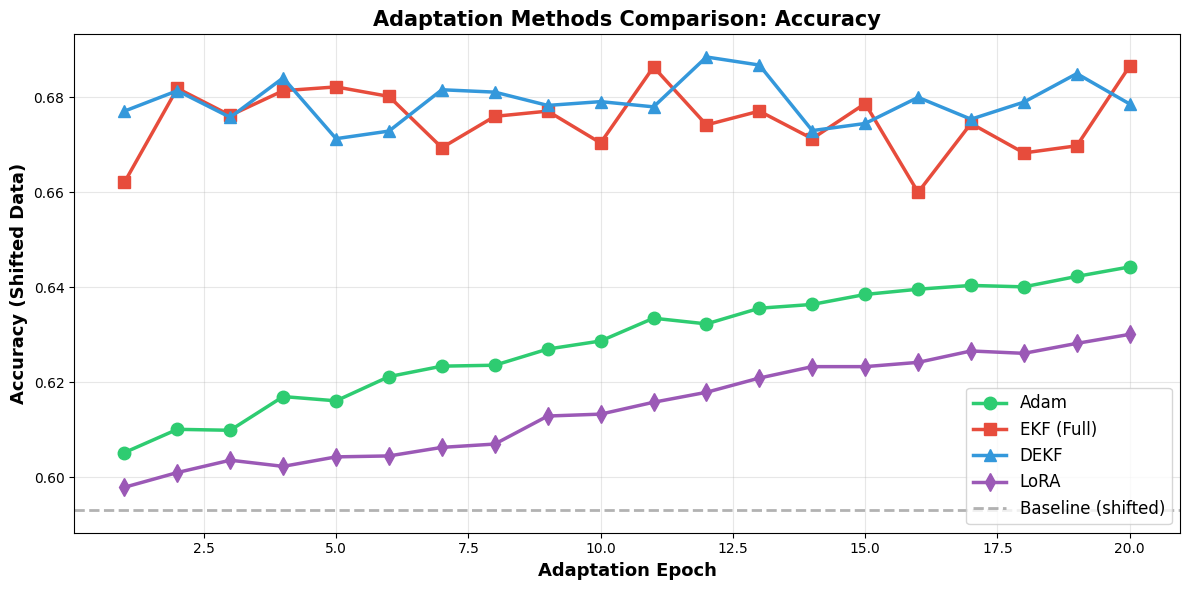

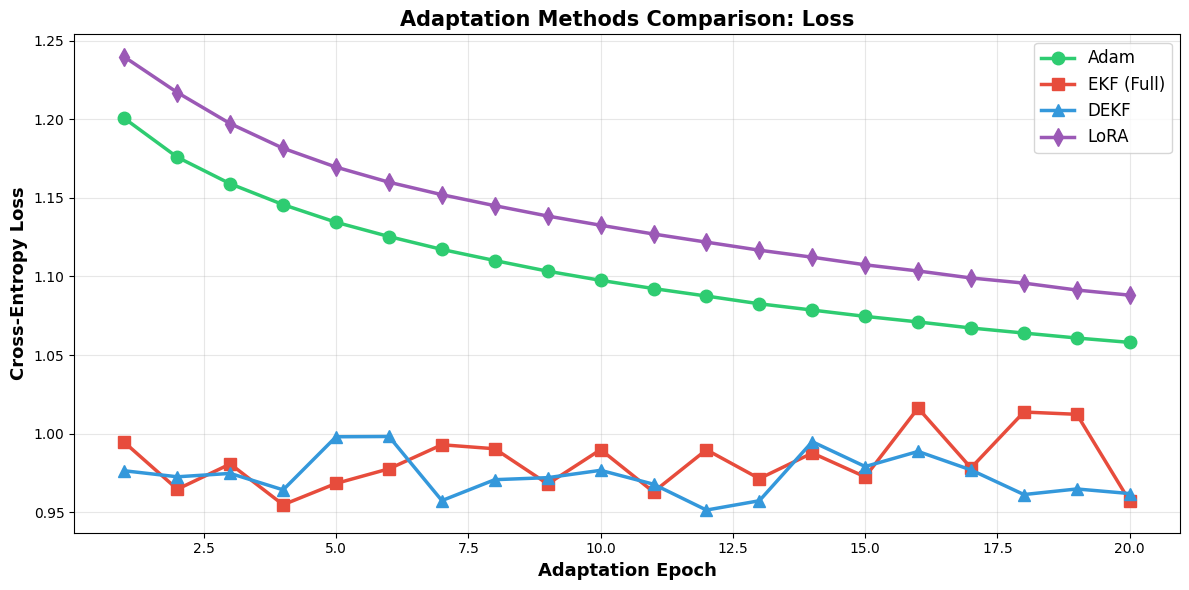

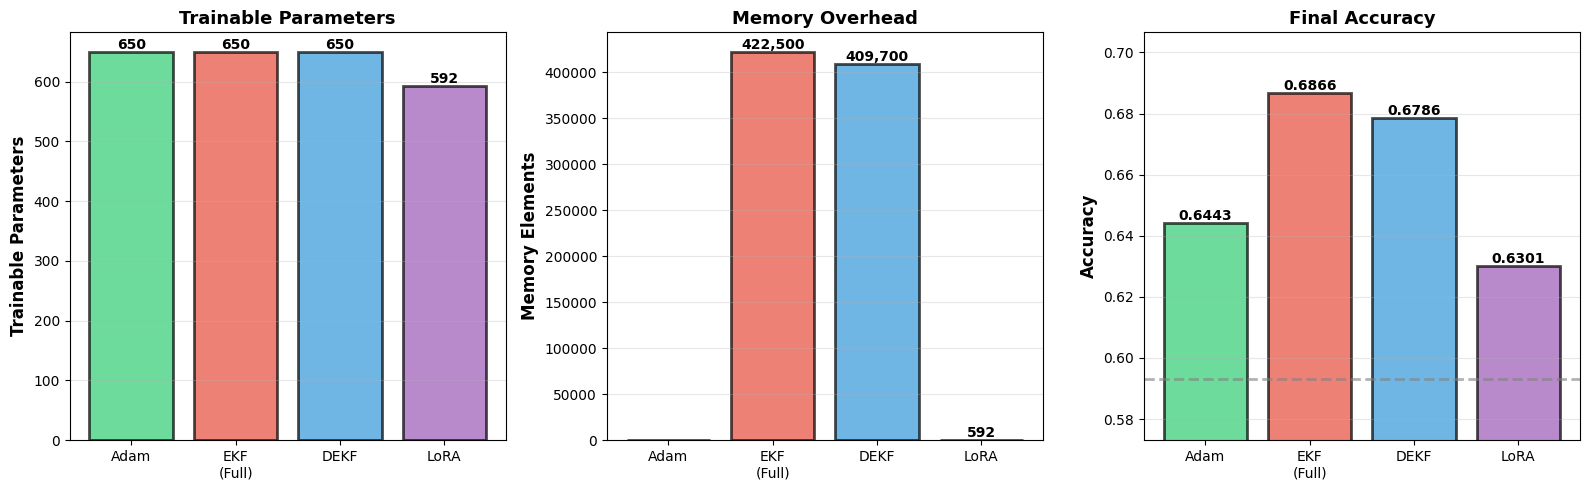

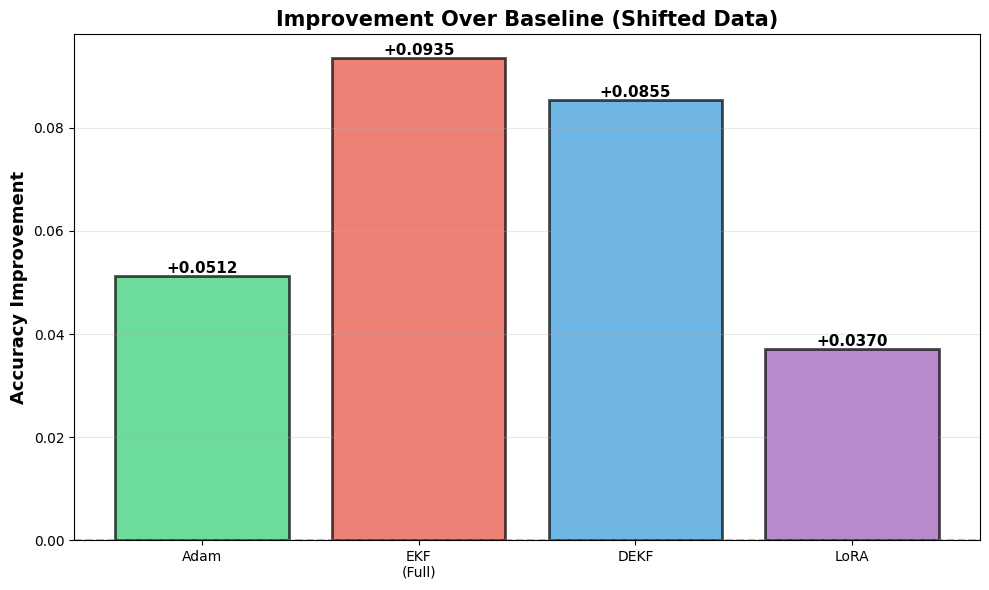

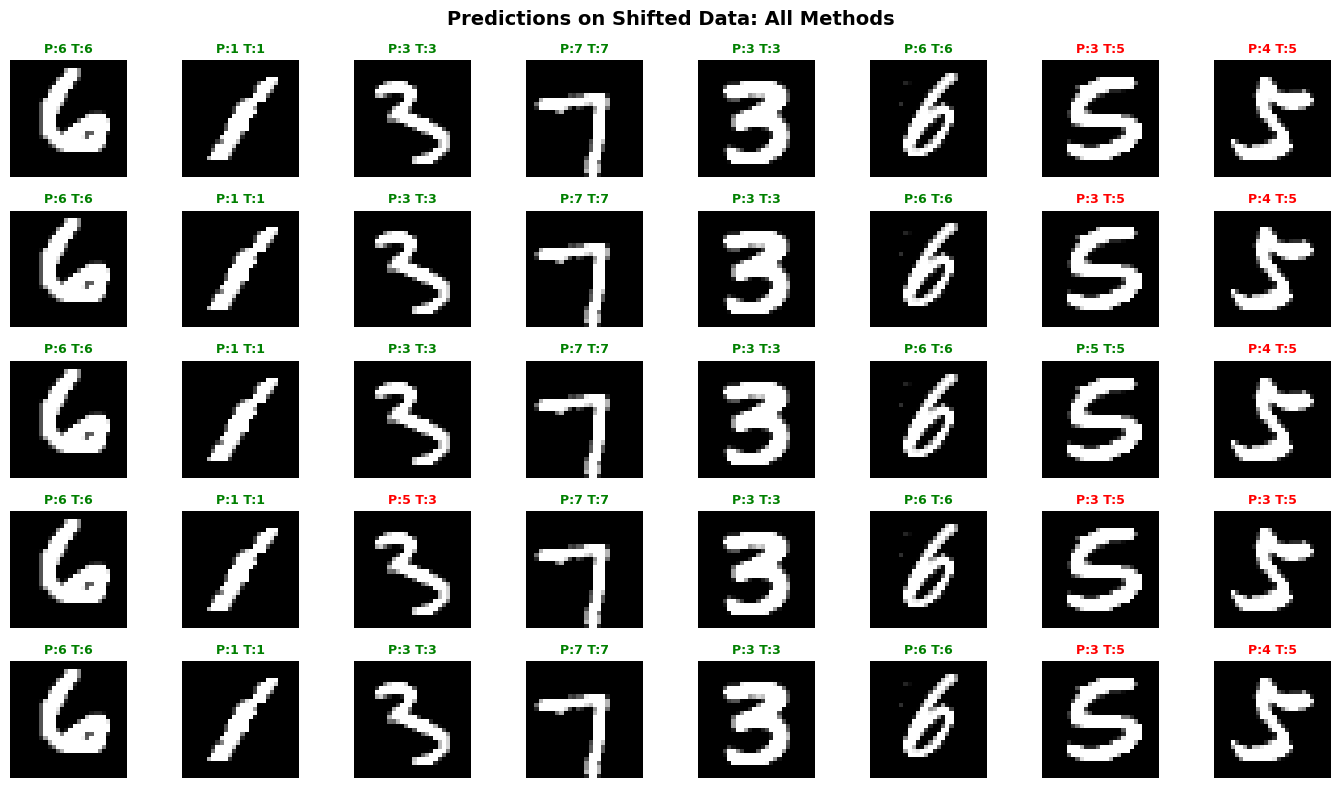

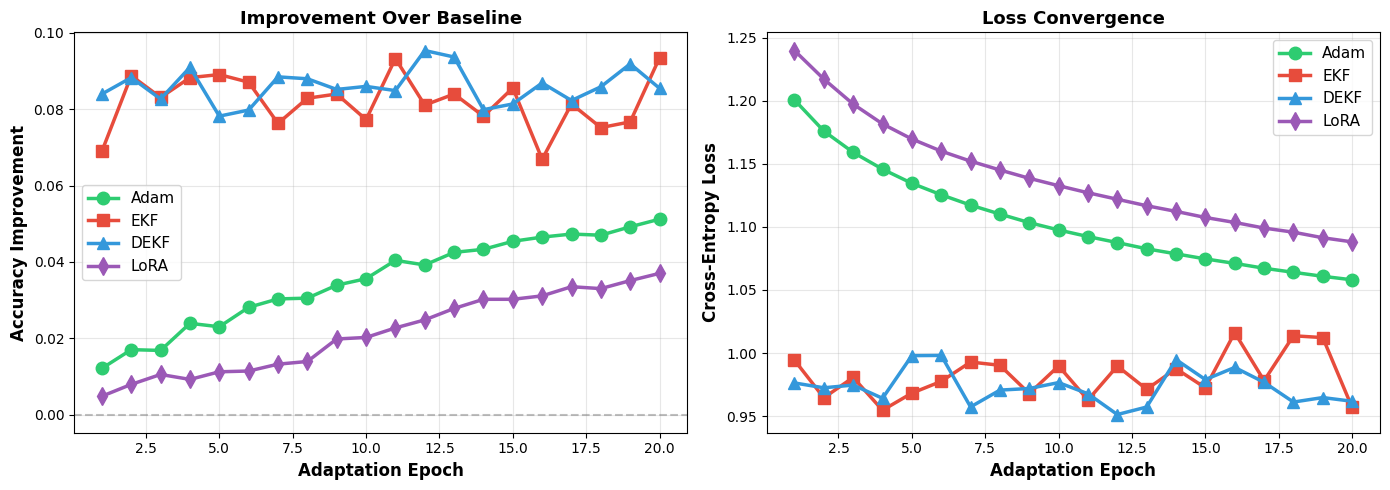

In [10]:
# =====================================
# 7. VISUALIZATIONS
# =====================================
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

epochs_adapt = np.arange(1, num_adapt_epochs + 1)

# Plot 1: Accuracy comparison
plt.figure(figsize=(12, 6))
plt.plot(epochs_adapt, results['adam']['accs'], 'o-', linewidth=2.5, markersize=9,
         label="Adam", color='#2ecc71')
plt.plot(epochs_adapt, results['ekf']['accs'], 's-', linewidth=2.5, markersize=9,
         label="EKF (Full)", color='#e74c3c')
plt.plot(epochs_adapt, results['dekf']['accs'], '^-', linewidth=2.5, markersize=9,
         label="DEKF", color='#3498db')
plt.plot(epochs_adapt, results['lora']['accs'], 'd-', linewidth=2.5, markersize=9,
         label="LoRA", color='#9b59b6')
plt.axhline(y=a_shift, color='gray', linestyle='--', linewidth=2, alpha=0.6,
            label='Baseline (shifted)')
plt.xlabel("Adaptation Epoch", fontsize=13, fontweight='bold')
plt.ylabel("Accuracy (Shifted Data)", fontsize=13, fontweight='bold')
plt.title("Adaptation Methods Comparison: Accuracy", fontsize=15, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Loss comparison
plt.figure(figsize=(12, 6))
plt.plot(epochs_adapt, results['adam']['losses'], 'o-', linewidth=2.5, markersize=9,
         label="Adam", color='#2ecc71')
plt.plot(epochs_adapt, results['ekf']['losses'], 's-', linewidth=2.5, markersize=9,
         label="EKF (Full)", color='#e74c3c')
plt.plot(epochs_adapt, results['dekf']['losses'], '^-', linewidth=2.5, markersize=9,
         label="DEKF", color='#3498db')
plt.plot(epochs_adapt, results['lora']['losses'], 'd-', linewidth=2.5, markersize=9,
         label="LoRA", color='#9b59b6')
plt.xlabel("Adaptation Epoch", fontsize=13, fontweight='bold')
plt.ylabel("Cross-Entropy Loss", fontsize=13, fontweight='bold')
plt.title("Adaptation Methods Comparison: Loss", fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Computational complexity comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

methods = ['Adam', 'EKF\n(Full)', 'DEKF', 'LoRA']
colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6']

# Trainable parameters
trainable_params = [fc_param_count, fc_param_count, fc_param_count, num_lora_params]
bars = axes[0].bar(methods, trainable_params, color=colors, alpha=0.7,
                   edgecolor='black', linewidth=2)
axes[0].set_ylabel('Trainable Parameters', fontsize=12, fontweight='bold')
axes[0].set_title('Trainable Parameters', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for bar, val in zip(bars, trainable_params):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:,}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Memory overhead
memory_overhead = [0, state_dim**2, dekf_cov_size, num_lora_params]
bars = axes[1].bar(methods, memory_overhead, color=colors, alpha=0.7,
                   edgecolor='black', linewidth=2)
axes[1].set_ylabel('Memory Elements', fontsize=12, fontweight='bold')
axes[1].set_title('Memory Overhead', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for bar, val in zip(bars, memory_overhead):
    height = bar.get_height()
    if val > 0:
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:,}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Final accuracy
final_accs = [results['adam']['accs'][-1], results['ekf']['accs'][-1],
              results['dekf']['accs'][-1], results['lora']['accs'][-1]]
bars = axes[2].bar(methods, final_accs, color=colors, alpha=0.7,
                   edgecolor='black', linewidth=2)
axes[2].axhline(y=a_shift, color='gray', linestyle='--', alpha=0.6, linewidth=2)
axes[2].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[2].set_title('Final Accuracy', fontsize=13, fontweight='bold')
axes[2].set_ylim([a_shift - 0.02, max(final_accs) + 0.02])
axes[2].grid(axis='y', alpha=0.3)
for bar, val in zip(bars, final_accs):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Plot 4: Improvement over baseline
improvements = [acc - a_shift for acc in final_accs]
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(methods, improvements, color=colors, alpha=0.7,
              edgecolor='black', linewidth=2)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
ax.set_ylabel('Accuracy Improvement', fontsize=13, fontweight='bold')
ax.set_title('Improvement Over Baseline (Shifted Data)', fontsize=15, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, improvements):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'+{val:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot 5: Prediction visualization
def show_predictions_all(baseline_m, adam_m, ekf_m, dekf_m, lora_m, X, y):
    idx = np.random.choice(len(X), 8, replace=False)
    Xs, ys = X[idx], y[idx]

    pred_baseline = jnp.argmax(baseline_m(Xs), axis=-1)
    pred_adam = jnp.argmax(adam_m(Xs), axis=-1)
    pred_ekf = jnp.argmax(ekf_m(Xs), axis=-1)
    pred_dekf = jnp.argmax(dekf_m(Xs), axis=-1)
    pred_lora = jnp.argmax(lora_m(Xs), axis=-1)

    fig, axes = plt.subplots(5, 8, figsize=(14, 8))

    for i in range(8):
        # Baseline
        axes[0, i].imshow(Xs[i], cmap="gray")
        color = 'green' if pred_baseline[i] == ys[i] else 'red'
        axes[0, i].set_title(f"P:{pred_baseline[i]} T:{ys[i]}",
                            fontsize=9, color=color, fontweight='bold')
        axes[0, i].axis("off")

        # Adam
        axes[1, i].imshow(Xs[i], cmap="gray")
        color = 'green' if pred_adam[i] == ys[i] else 'red'
        axes[1, i].set_title(f"P:{pred_adam[i]} T:{ys[i]}",
                            fontsize=9, color=color, fontweight='bold')
        axes[1, i].axis("off")

        # EKF
        axes[2, i].imshow(Xs[i], cmap="gray")
        color = 'green' if pred_ekf[i] == ys[i] else 'red'
        axes[2, i].set_title(f"P:{pred_ekf[i]} T:{ys[i]}",
                            fontsize=9, color=color, fontweight='bold')
        axes[2, i].axis("off")

        # DEKF
        axes[3, i].imshow(Xs[i], cmap="gray")
        color = 'green' if pred_dekf[i] == ys[i] else 'red'
        axes[3, i].set_title(f"P:{pred_dekf[i]} T:{ys[i]}",
                            fontsize=9, color=color, fontweight='bold')
        axes[3, i].axis("off")

        # LoRA
        axes[4, i].imshow(Xs[i], cmap="gray")
        color = 'green' if pred_lora[i] == ys[i] else 'red'
        axes[4, i].set_title(f"P:{pred_lora[i]} T:{ys[i]}",
                            fontsize=9, color=color, fontweight='bold')
        axes[4, i].axis("off")

    axes[0, 0].set_ylabel("Baseline", rotation=0, labelpad=50, fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel("Adam", rotation=0, labelpad=50, fontsize=11, fontweight='bold')
    axes[2, 0].set_ylabel("EKF", rotation=0, labelpad=50, fontsize=11, fontweight='bold')
    axes[3, 0].set_ylabel("DEKF", rotation=0, labelpad=50, fontsize=11, fontweight='bold')
    axes[4, 0].set_ylabel("LoRA", rotation=0, labelpad=50, fontsize=11, fontweight='bold')

    plt.suptitle("Predictions on Shifted Data: All Methods", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_predictions_all(baseline_model, adam_model, ekf_model, dekf_model, lora_model,
                     X_test_shifted, y_test_shifted)

# Plot 6: Convergence rate comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy improvement per epoch
adam_improvements = [acc - a_shift for acc in results['adam']['accs']]
ekf_improvements = [acc - a_shift for acc in results['ekf']['accs']]
dekf_improvements = [acc - a_shift for acc in results['dekf']['accs']]
lora_improvements = [acc - a_shift for acc in results['lora']['accs']]

axes[0].plot(epochs_adapt, adam_improvements, 'o-', linewidth=2.5, markersize=9,
            label="Adam", color='#2ecc71')
axes[0].plot(epochs_adapt, ekf_improvements, 's-', linewidth=2.5, markersize=9,
            label="EKF", color='#e74c3c')
axes[0].plot(epochs_adapt, dekf_improvements, '^-', linewidth=2.5, markersize=9,
            label="DEKF", color='#3498db')
axes[0].plot(epochs_adapt, lora_improvements, 'd-', linewidth=2.5, markersize=9,
            label="LoRA", color='#9b59b6')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
axes[0].set_xlabel("Adaptation Epoch", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Accuracy Improvement", fontsize=12, fontweight='bold')
axes[0].set_title("Improvement Over Baseline", fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss convergence
axes[1].plot(epochs_adapt, results['adam']['losses'], 'o-', linewidth=2.5, markersize=9,
            label="Adam", color='#2ecc71')
axes[1].plot(epochs_adapt, results['ekf']['losses'], 's-', linewidth=2.5, markersize=9,
            label="EKF", color='#e74c3c')
axes[1].plot(epochs_adapt, results['dekf']['losses'], '^-', linewidth=2.5, markersize=9,
            label="DEKF", color='#3498db')
axes[1].plot(epochs_adapt, results['lora']['losses'], 'd-', linewidth=2.5, markersize=9,
            label="LoRA", color='#9b59b6')
axes[1].set_xlabel("Adaptation Epoch", fontsize=12, fontweight='bold')
axes[1].set_ylabel("Cross-Entropy Loss", fontsize=12, fontweight='bold')
axes[1].set_title("Loss Convergence", fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [11]:
# =====================================
# 8. COMPREHENSIVE SUMMARY
# =====================================
print("\n" + "="*70)
print("COMPREHENSIVE SUMMARY")
print("="*70)

print(f"\n{'Metric':<40} {'Baseline':<12} {'Adam':<12} {'EKF':<12} {'DEKF':<12} {'LoRA':<12}")
print("-" * 100)

print(f"{'Accuracy (original data)':<40} {test_accs[-1]:<12.4f} {'-':<12} {'-':<12} {'-':<12} {'-':<12}")
print(f"{'Accuracy (shifted - before)':<40} {a_shift:<12.4f} {a_shift:<12.4f} {a_shift:<12.4f} {a_shift:<12.4f} {a_shift:<12.4f}")
print(f"{'Accuracy (shifted - after)':<40} {'-':<12} {results['adam']['accs'][-1]:<12.4f} {results['ekf']['accs'][-1]:<12.4f} {results['dekf']['accs'][-1]:<12.4f} {results['lora']['accs'][-1]:<12.4f}")
print(f"{'Accuracy improvement':<40} {'-':<12} {(results['adam']['accs'][-1]-a_shift):<12.4f} {(results['ekf']['accs'][-1]-a_shift):<12.4f} {(results['dekf']['accs'][-1]-a_shift):<12.4f} {(results['lora']['accs'][-1]-a_shift):<12.4f}")
print(f"{'Final loss':<40} {l_shift:<12.4f} {results['adam']['losses'][-1]:<12.4f} {results['ekf']['losses'][-1]:<12.4f} {results['dekf']['losses'][-1]:<12.4f} {results['lora']['losses'][-1]:<12.4f}")
print(f"{'Trainable parameters':<40} {fc_param_count:<12,} {fc_param_count:<12,} {fc_param_count:<12,} {fc_param_count:<12,} {num_lora_params:<12,}")
print(f"{'Memory overhead (elements)':<40} {'-':<12} {0:<12,} {state_dim**2:<12,} {dekf_cov_size:<12,} {num_lora_params:<12,}")

# Parameter change analysis
adam_change = l2_diff(baseline_model, adam_model)
ekf_change = l2_diff(baseline_model, ekf_model)
dekf_change = l2_diff(baseline_model, dekf_model)

# For LoRA, compute change differently since structure differs
# Compare the effective FC weights (W + BA)
baseline_fc_flat = ravel_pytree(nnx.state(baseline_model.fc))[0]
lora_fc_effective = (lora_model.fc_lora.weight.value +
                     lora_model.fc_lora.scaling *
                     (lora_model.fc_lora.lora_B.value @ lora_model.fc_lora.lora_A.value))
lora_fc_state = {'kernel': nnx.Param(lora_fc_effective.T),
                 'bias': nnx.Param(lora_model.fc_lora.bias.value)}
lora_fc_flat = ravel_pytree(lora_fc_state)[0]
lora_change = float(jnp.linalg.norm(baseline_fc_flat - lora_fc_flat))

print(f"{'Parameter L2 change':<40} {'-':<12} {adam_change:<12.6f} {ekf_change:<12.6f} {dekf_change:<12.6f} {lora_change:<12.6f}")

print(f"\n{'Method Characteristics:'}")
print(f"\n  Adam:")
print(f"    - Standard gradient descent optimizer")
print(f"    - No memory overhead beyond parameters")
print(f"    - Fast per-iteration updates")
print(f"    - Requires careful learning rate tuning")

print(f"\n  EKF (Full Covariance):")
print(f"    - Bayesian parameter estimation")
print(f"    - Full covariance matrix: {state_dim}x{state_dim} = {state_dim**2:,} elements")
print(f"    - Provides uncertainty quantification")
print(f"    - High memory and computational cost")

print(f"\n  DEKF (Decoupled):")
print(f"    - Factorized covariance matrices")
print(f"    - Total covariance: {dekf_cov_size:,} elements")
print(f"    - Memory reduction: {state_dim**2 / dekf_cov_size:.2f}x vs full EKF")
print(f"    - Maintains Bayesian uncertainty")

print(f"\n  LoRA:")
print(f"    - Low-rank matrix factorization")
print(f"    - Rank: {lora_rank}, Parameters: {num_lora_params}")
print(f"    - Parameter efficiency: {num_lora_params / fc_param_count:.2%}")
print(f"    - Deterministic gradient-based training")

# Ranking
methods_rank = ['Adam', 'EKF', 'DEKF', 'LoRA']
accs_rank = [results['adam']['accs'][-1], results['ekf']['accs'][-1],
             results['dekf']['accs'][-1], results['lora']['accs'][-1]]
sorted_indices = np.argsort(accs_rank)[::-1]

print(f"\n{'Accuracy Ranking:'}")
for rank, idx in enumerate(sorted_indices, 1):
    print(f"  {rank}. {methods_rank[idx]}: {accs_rank[idx]:.4f}")

print(f"\n{'='*70}\n")


COMPREHENSIVE SUMMARY

Metric                                   Baseline     Adam         EKF          DEKF         LoRA        
----------------------------------------------------------------------------------------------------
Accuracy (original data)                 0.5921       -            -            -            -           
Accuracy (shifted - before)              0.5931       0.5931       0.5931       0.5931       0.5931      
Accuracy (shifted - after)               -            0.6443       0.6866       0.6786       0.6301      
Accuracy improvement                     -            0.0512       0.0935       0.0855       0.0370      
Final loss                               1.2528       1.0580       0.9568       0.9618       1.0881      
Trainable parameters                     650          650          650          650          592         
Memory overhead (elements)               -            0            422,500      409,700      592         
Parameter L2 change        